<a href="https://colab.research.google.com/github/roshansadath/COMP6721_Winter2023_GroupN/blob/main/Transfer%20Learning/Inceptionv3D3_D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os, time, random, warnings, torch
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models.inception import InceptionOutputs
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter("ignore")
%run "/content/drive/My Drive/Colab Notebooks/utils.ipynb"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#data_path = "/content/drive/My Drive/Simple_Chest_XRay/"
model_path = "/content/drive/My Drive/NIH_Chest_XRay/"
data_path= "/content/drive/My Drive/Harvard_Chest_XRay/"

sample_ratio = 1
batch_size = 96
num_epochs = 20

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
def data_sampling(indices):
  return torch.utils.data.sampler.SubsetRandomSampler(indices)

In [ ]:
def save_metrics(loss, accuracy, model):
  np.save("{}{}_train_loss.npy".format(data_path, model), loss)
  np.save("{}{}_train_accuracy.npy".format(data_path, model), accuracy)

**DATA PREPROCESSING**


In [ ]:
data_transforms = transforms.Compose([
  transforms.Resize((299, 299)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Get dataset from folder and apply data transforms
dataset = datasets.ImageFolder(root = "{}data".format(data_path), transform = data_transforms)

# Get a sample of the data randomly
num_samples = int(len(dataset) * sample_ratio)
indices = np.random.choice(range(len(dataset)), num_samples, replace = False)

# Split the data into training, test, and validation sets
train_size = int(0.7 * num_samples)
test_size = int(0.2 * num_samples)
val_size = num_samples - train_size - test_size

train_indices = indices[ : train_size]
test_indices = indices[train_size : train_size + test_size]
val_indices = indices[train_size + test_size : ]

samples = [data_sampling(i) for i in [train_indices, test_indices, val_indices]]

# Create data loaders for training, test, and validation sets
train_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[0])
test_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[1])
val_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[2])

**PERFORM TRANSFER LEARNING ON DATASET 2 BY DEEP-TUNING**


In [ ]:
# Define the Inceptionv3 model and load the pretrained model from Dataset3 and perform Fine-tuning
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained = False)
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))

state_dict = torch.load("{}inceptionv3.pth".format(model_path))

state_dict['fc.weight'] = model.fc.weight
state_dict['fc.bias'] = model.fc.bias
model.load_state_dict(state_dict)

for encoderparams, classifierparams in zip(model.parameters(), model.fc.parameters()):
  encoderparams.requires_grad, classifierparams.requires_grad = False, True

model.to(device)
"""
input = torch.randn(1, 3, 299, 299).to(device)
flops, params = thop.profile(model, inputs = (input,))

print("Number of FLOPs: {}G".format(flops / (1000 ** 3)))
print("Number of Parameters: {}M".format(params /(1000 ** 2)))
"""
# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "TL_Inceptionv3", num_epochs)

Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
Epoch 1/20: 100%|██████████| 27/27 [26:57<00:00, 59.90s/batch, Accuracy=0.334, Loss=0.54, Precision=0.328, Recall=0.269, F1 Score=0.255]


VALIDATION: Accuracy: 0.3370 | Loss: 1.5450 | Recall: 0.2623 | Precision: 0.1276 | F-score: 0.1713



Epoch 2/20: 100%|██████████| 27/27 [00:46<00:00,  1.72s/batch, Accuracy=0.383, Loss=0.567, Precision=0.334, Recall=0.299, F1 Score=0.289]


VALIDATION: Accuracy: 0.4318 | Loss: 1.3726 | Recall: 0.3602 | Precision: 0.4780 | F-score: 0.2985



Epoch 3/20: 100%|██████████| 27/27 [00:48<00:00,  1.79s/batch, Accuracy=0.464, Loss=0.603, Precision=0.366, Recall=0.338, F1 Score=0.333]


VALIDATION: Accuracy: 0.5153 | Loss: 1.1806 | Recall: 0.4390 | Precision: 0.5401 | F-score: 0.4290



Epoch 4/20: 100%|██████████| 27/27 [00:48<00:00,  1.80s/batch, Accuracy=0.506, Loss=0.567, Precision=0.398, Recall=0.369, F1 Score=0.367]


VALIDATION: Accuracy: 0.4708 | Loss: 1.2749 | Recall: 0.4624 | Precision: 0.6032 | F-score: 0.4578



Epoch 5/20: 100%|██████████| 27/27 [00:48<00:00,  1.80s/batch, Accuracy=0.519, Loss=0.364, Precision=0.419, Recall=0.392, F1 Score=0.391]


VALIDATION: Accuracy: 0.4345 | Loss: 1.3473 | Recall: 0.3468 | Precision: 0.4976 | F-score: 0.3387



Epoch 6/20: 100%|██████████| 27/27 [00:48<00:00,  1.80s/batch, Accuracy=0.553, Loss=0.622, Precision=0.438, Recall=0.412, F1 Score=0.412]


VALIDATION: Accuracy: 0.5487 | Loss: 1.1730 | Recall: 0.5497 | Precision: 0.5766 | F-score: 0.5232



Epoch 7/20: 100%|██████████| 27/27 [00:48<00:00,  1.81s/batch, Accuracy=0.601, Loss=0.457, Precision=0.459, Recall=0.433, F1 Score=0.435]


VALIDATION: Accuracy: 0.4485 | Loss: 1.5440 | Recall: 0.3518 | Precision: 0.5432 | F-score: 0.3358



Epoch 8/20: 100%|██████████| 27/27 [00:49<00:00,  1.82s/batch, Accuracy=0.56, Loss=0.35, Precision=0.468, Recall=0.445, F1 Score=0.447]


VALIDATION: Accuracy: 0.6212 | Loss: 1.0103 | Recall: 0.5730 | Precision: 0.6840 | F-score: 0.5586



Epoch 9/20: 100%|██████████| 27/27 [00:50<00:00,  1.85s/batch, Accuracy=0.622, Loss=0.518, Precision=0.485, Recall=0.461, F1 Score=0.464]


VALIDATION: Accuracy: 0.6100 | Loss: 0.9983 | Recall: 0.6038 | Precision: 0.6456 | F-score: 0.5730



Epoch 10/20: 100%|██████████| 27/27 [00:50<00:00,  1.86s/batch, Accuracy=0.649, Loss=0.654, Precision=0.5, Recall=0.476, F1 Score=0.48]


VALIDATION: Accuracy: 0.6156 | Loss: 0.9555 | Recall: 0.5921 | Precision: 0.6330 | F-score: 0.5845



Epoch 11/20: 100%|██████████| 27/27 [00:49<00:00,  1.84s/batch, Accuracy=0.635, Loss=0.453, Precision=0.511, Recall=0.488, F1 Score=0.493]


VALIDATION: Accuracy: 0.6435 | Loss: 0.9597 | Recall: 0.6163 | Precision: 0.6796 | F-score: 0.6086



Epoch 12/20: 100%|██████████| 27/27 [00:50<00:00,  1.86s/batch, Accuracy=0.637, Loss=0.494, Precision=0.521, Recall=0.498, F1 Score=0.503]


VALIDATION: Accuracy: 0.6072 | Loss: 1.0147 | Recall: 0.5543 | Precision: 0.6241 | F-score: 0.5388



Epoch 13/20: 100%|██████████| 27/27 [00:50<00:00,  1.86s/batch, Accuracy=0.666, Loss=0.277, Precision=0.53, Recall=0.509, F1 Score=0.514]


VALIDATION: Accuracy: 0.6741 | Loss: 0.8302 | Recall: 0.6499 | Precision: 0.6726 | F-score: 0.6544



Epoch 14/20: 100%|██████████| 27/27 [00:50<00:00,  1.88s/batch, Accuracy=0.662, Loss=0.248, Precision=0.539, Recall=0.518, F1 Score=0.523]


VALIDATION: Accuracy: 0.5599 | Loss: 1.1214 | Recall: 0.5084 | Precision: 0.6213 | F-score: 0.5134



Epoch 15/20: 100%|██████████| 27/27 [00:50<00:00,  1.88s/batch, Accuracy=0.67, Loss=0.163, Precision=0.546, Recall=0.526, F1 Score=0.531]


VALIDATION: Accuracy: 0.6379 | Loss: 0.8952 | Recall: 0.6091 | Precision: 0.6695 | F-score: 0.5931



Epoch 16/20: 100%|██████████| 27/27 [00:50<00:00,  1.89s/batch, Accuracy=0.705, Loss=0.464, Precision=0.556, Recall=0.536, F1 Score=0.541]


VALIDATION: Accuracy: 0.6797 | Loss: 0.7792 | Recall: 0.6558 | Precision: 0.6735 | F-score: 0.6556



Epoch 17/20: 100%|██████████| 27/27 [00:51<00:00,  1.91s/batch, Accuracy=0.722, Loss=0.32, Precision=0.565, Recall=0.546, F1 Score=0.551]


VALIDATION: Accuracy: 0.6964 | Loss: 0.8033 | Recall: 0.6512 | Precision: 0.6836 | F-score: 0.6594



Epoch 18/20: 100%|██████████| 27/27 [00:51<00:00,  1.91s/batch, Accuracy=0.684, Loss=0.356, Precision=0.571, Recall=0.552, F1 Score=0.558]


VALIDATION: Accuracy: 0.6741 | Loss: 0.8211 | Recall: 0.6636 | Precision: 0.6964 | F-score: 0.6621



Epoch 19/20: 100%|██████████| 27/27 [00:51<00:00,  1.91s/batch, Accuracy=0.712, Loss=0.438, Precision=0.578, Recall=0.56, F1 Score=0.565]


VALIDATION: Accuracy: 0.6574 | Loss: 0.8433 | Recall: 0.6196 | Precision: 0.6571 | F-score: 0.6202



Epoch 20/20: 100%|██████████| 27/27 [00:51<00:00,  1.92s/batch, Accuracy=0.726, Loss=0.443, Precision=0.584, Recall=0.567, F1 Score=0.572]


VALIDATION: Accuracy: 0.6379 | Loss: 0.9293 | Recall: 0.6376 | Precision: 0.7052 | F-score: 0.6353



**SAVE MODEL PARAMETERS**

In [ ]:
torch.save(model.state_dict(), "{}TL_inceptionv3.pth".format(data_path))

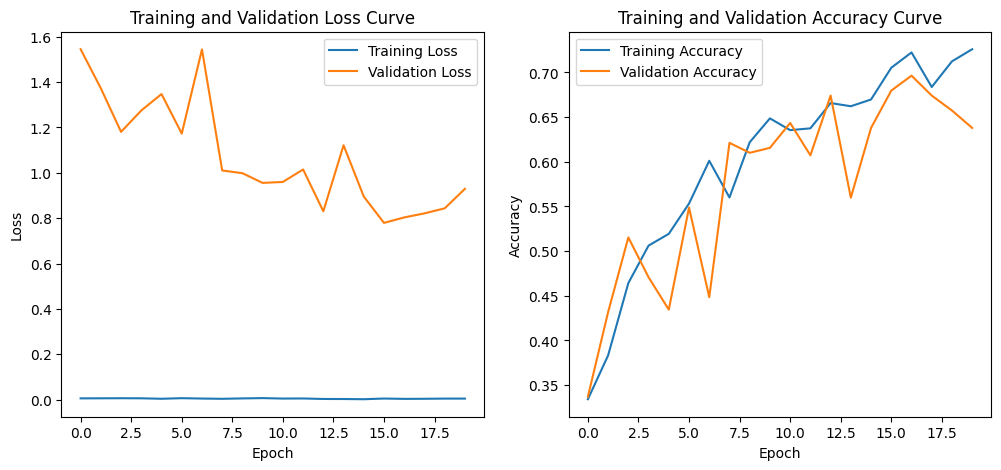

In [ ]:
#Plot the Accuracy and Loss Curves of the model for Training and Validation
# plot_model_curves(losses, accuracies, v_accuracies, v_losses)
#Plotting the Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(losses, label = "Training Loss")
ax1.plot(v_losses, label = "Validation Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Curve')
ax1.legend()

ax2.plot(accuracies, label = "Training Accuracy")
ax2.plot(v_accuracies, label = "Validation Accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy Curve')
ax2.legend()

plt.show()

**EVALUATE MODEL ON VALIDATION AND TEST SET**

TEST: Accuracy: 0.5992 | Loss: 1.0312 | Recall: 0.6028 | Precision: 0.6501 | F-score: 0.5880



<Figure size 800x800 with 0 Axes>

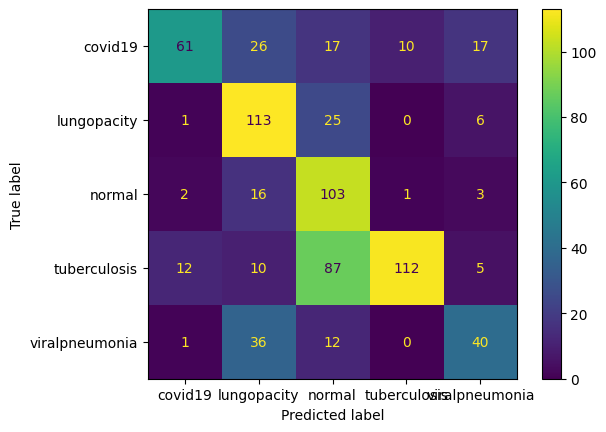

In [ ]:
#Evaluate Model on Test Set
evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "Inceptionv3")

**PLOT TSNE AND WITHIN-CLASS VARIANCE**

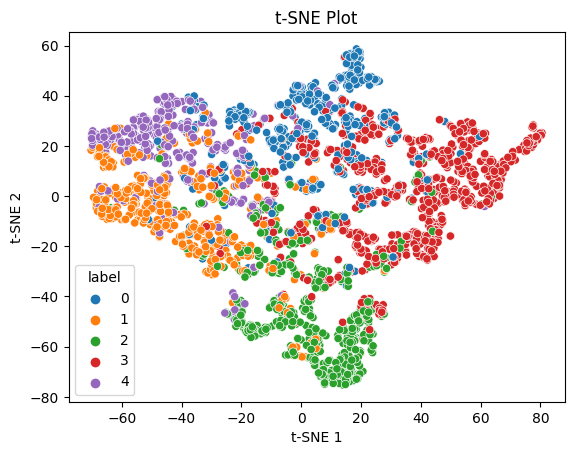

In [ ]:
#Obtain the TSNE Plot
plot_TSNE(train_loader, device, model)

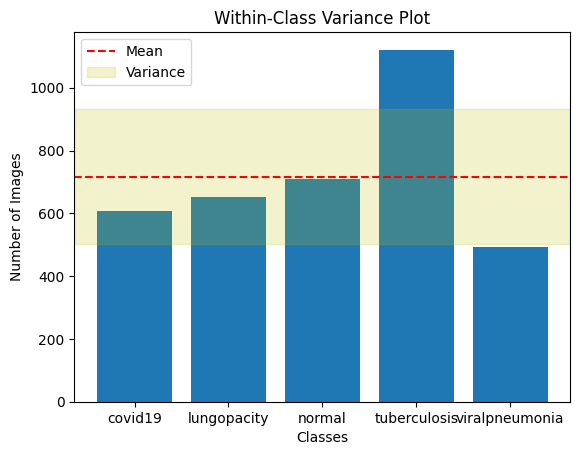

In [ ]:
#Plot the Within-Class Variance of the dataset
plot_within_class_variance(dataset)